In [1]:
import sys
sys.path.append("../") # go to parent dir
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

In [4]:
def compare_sets(set1, set2):
    union = set1.union(set2)
    set_1_unique = set1.difference(set2)
    set_2_unique = set2.difference(set1)
    
    print(f"set 1 size: {len(set1)}")
    print(f"set 2 size: {len(set2)}")
    print(f"Union size: {len(union)}")
    print(f"set 1 unique elements: {len(set_1_unique)}")
    print(f"set 2 unique elements: {len(set_2_unique)}")
    return

### Import data

In [5]:
item_categories = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv("../data/items.csv")
sales_train = pd.read_csv("../data/sales_train.csv")
shops = pd.read_csv("../data/shops.csv")
test = pd.read_csv("../data/test.csv")
sample_subm = pd.read_csv('../data/sample_submission.csv')

In [6]:
# Nov 2015
test['date_block_num'] = 34

In [7]:
# Seems useless - item_name -> item_id, item_category_id mappings are already inside items dataframe
item_categories.shape

(84, 2)

In [8]:
items.shape

(22170, 3)

In [9]:
sales_train.shape

(2935849, 6)

In [10]:
# Seems useless - Only maps to shop name
shops.shape

(60, 2)

In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Let's aggregate the data monthly, as predictions are expected to be monthly as well

In [13]:
from src.staging import create_dataset

In [14]:
all_data = create_dataset(sales_train)

In [15]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


<AxesSubplot:ylabel='Frequency'>

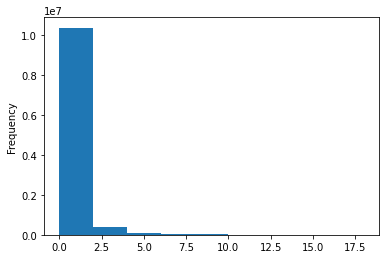

In [16]:
all_data['target'].plot(kind='hist', bins = np.arange(0,20,2))

#### All shops are included in train -> Test has only a subset of these shops

In [17]:
compare_sets(set(all_data['shop_id'].unique()), set(test['shop_id'].unique()))

set 1 size: 60
set 2 size: 42
Union size: 60
set 1 unique elements: 18
set 2 unique elements: 0


### There are new items in test never seen in train 

In [18]:
compare_sets(set(all_data['item_id'].unique()), set(test['item_id'].unique()))

set 1 size: 21807
set 2 size: 5100
Union size: 22170
set 1 unique elements: 17070
set 2 unique elements: 363


In [19]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [20]:
all_data['item_category_id'] = all_data['item_id'].map(items.set_index("item_id")['item_category_id'])

### The total quantity of products vary a lot in the training set per month, whereas all the shops in test set have the same qty of products (5100)

In [21]:
### Let's mean encode shop_id and item_id

In [22]:
from src.processing import mean_encode

In [23]:
all_data['category_enc_em'] = mean_encode(all_data, ['item_category_id'], 'target')
all_data['item_enc_em'] = mean_encode(all_data, ['item_id'],'target')
all_data['shop_enc_em'] = mean_encode(all_data, ['shop_id'],'target')
all_data['item_shop_enc_em'] = mean_encode(all_data, ['item_id','shop_id'],'target')

In [24]:
all_data.corr()['target']

shop_id             0.009222
item_id            -0.014021
date_block_num     -0.002233
target              1.000000
item_category_id   -0.028386
category_enc_em     0.389759
item_enc_em         0.502820
shop_enc_em         0.071617
item_shop_enc_em    0.639986
Name: target, dtype: float64

In [25]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num']

In [36]:
y = all_data['target']
X = all_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
rf = RandomForestRegressor(n_estimators=7,max_depth=7,max_features= 0.7, n_jobs=7)
rf.fit(X_train.fillna(-999), y_train)

RandomForestRegressor(max_depth=7, max_features=0.7, n_estimators=7, n_jobs=7)

In [61]:
mean_squared_error(rf.predict(X_train.fillna(-999)), y_train)

3.901804748778644

In [62]:
mean_squared_error(rf.predict(X_test.fillna(-999)), y_test)

6.191561717405774

#### Basemodel -> Test MSE = 6.191

#### Add more features

In [27]:
from src.processing import add_prev_k_months_feature, add_aggregations

In [28]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,category_enc_em,item_enc_em,shop_enc_em,item_shop_enc_em
139255,0,19,0,0.0,40,NaN,NaN,NaN,NaN
141495,0,27,0,0.0,19,NaN,NaN,0.0,NaN
144968,0,28,0,0.0,30,NaN,NaN,0.0,NaN
142661,0,29,0,0.0,23,NaN,NaN,0.0,NaN
138947,0,32,0,6.0,40,0.0,NaN,0.0,NaN


In [29]:
all_data = add_prev_k_months_feature(df = all_data, k_list = [1,2,3,13], feat_name='target',unique_identifiers=['shop_id','item_id'])

22.7% of target_-1 are null
28.499999999999996% of target_-2 are null
34.0% of target_-3 are null
75.4% of target_-13 are null


In [30]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,category_enc_em,item_enc_em,shop_enc_em,item_shop_enc_em,target_-1,target_-2,target_-3,target_-13
0,0,19,0,0.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,19,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
2,0,28,0,0.0,30,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN
3,0,29,0,0.0,23,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,40,0.0,NaN,0.0,NaN,10.0,NaN,NaN,NaN


- Average price of product in a shop in the previous month
- Average price of a product in all shops in the last month
- Ratio of the above two

- 
- 

- Last month total sales / last 12 month total sales

- Maximum disccount within a month
- Last month price difference


In [31]:
all_data = add_aggregations(all_data,sales_train,groupby_cols=['date_block_num','item_id', 'shop_id'], target_name='item_price')
all_data = add_aggregations(all_data,sales_train,groupby_cols=['date_block_num','item_id'], target_name='item_price')

In [32]:
all_data["mean_mean_item_discount"] = all_data["item_price_mean-by-item_id-shop_id-1"] / all_data["item_price_mean-by-item_id-1"]
all_data["mean_min_item_discount"] = all_data["item_price_mean-by-item_id-shop_id-1"] / all_data["item_price_min-by-item_id-1"]

In [39]:
"""price_per_shop = sales_train.groupby(['date_block_num','item_id', 'shop_id'])['item_price'].agg(['min','max','mean']).reset_index(level = ['shop_id'])
price_per_shop = price_per_shop.rename(columns={"min":"min_per_shop", "max" : "max_per_shop", "mean": "mean_per_shop"})
prices_per_item = sales_train.groupby(['date_block_num','item_id'])['item_price'].agg(['min','max','mean'])
prices_per_item = prices_per_item.rename(columns={"min":"min_per_item", "max" : "max_per_item", "mean": "mean_per_item"} )
price_df = price_per_shop.merge(prices_per_item, how = 'left', left_index=True, right_index=True).reset_index()
price_df['date_block_num_-1'] = price_df['date_block_num']-1

price_df['mean_mean_item_discount'] = ( price_df['mean_per_shop'] / price_df['mean_per_item']) - 1
price_df['mean_min_item_discount'] = ( price_df['mean_per_shop'] / price_df['min_per_item']) - 1
price_df['mean_max_item_discount'] = ( price_df['mean_per_shop'] / price_df['max_per_item']) - 1

all_data = all_data.merge(price_df.drop(columns = ['date_block_num']), 
               how = 'left',
               left_on = ['shop_id', 'item_id', 'date_block_num'],
               right_on = ['shop_id', 'item_id', 'date_block_num_-1'])

all_data = all_data.fillna(-999)

"""

In [33]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num', 'target_-1','target_-2','target_-3', 'target_-13', 'mean_mean_item_discount','mean_min_item_discount']
y = all_data['target']
X = all_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
%%time
rf = RandomForestRegressor(n_estimators=7,max_depth=7,max_features= 0.7, n_jobs=7)
rf.fit(X_train.fillna(-999), y_train)

CPU times: user 2min 41s, sys: 2.32 s, total: 2min 43s
Wall time: 30 s


RandomForestRegressor(max_depth=7, max_features=0.7, n_estimators=7, n_jobs=7)

In [35]:
mean_squared_error(rf.predict(X_train.fillna(-999)), y_train)

3.2981658149680095

In [36]:
mean_squared_error(rf.predict(X_test.fillna(-999)), y_test)

6.050274483293847

In [ ]:
"""xgb_reg = xgb.XGBRegressor(max_depth=6, n_estimators=100, n_jobs=8,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, verbosity = 1)

xgb_reg.fit(X_train, y_train)"""

### Very small improvement

In [49]:
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']

In [50]:
total_rev_shop = sales_train.groupby(['date_block_num','shop_id'])['revenue'].sum().reset_index().copy()
total_rev_shop = total_rev_shop.rename(columns = {'revenue' : 'revenue_shop'})

In [51]:
total_rev_shop['date_block_num_-1'] = total_rev_shop['date_block_num'] - 1
total_rev_shop['date_block_num_-13'] = total_rev_shop['date_block_num'] - 13

In [52]:
total_rev_shop_1 = total_rev_shop.set_index(["date_block_num_-1", "shop_id"])['revenue_shop'].reset_index().rename(columns={"revenue_shop":"revenue_shop_-1"})
total_rev_shop_13 = total_rev_shop.set_index(["date_block_num_-13","shop_id"])['revenue_shop'].reset_index().rename(columns={"revenue_shop":"revenue_shop_-13"})

In [53]:
total_rev_item = sales_train.groupby(['date_block_num','item_id'])['revenue'].sum().reset_index().copy()
total_rev_item = total_rev_item.rename(columns={"revenue":"revenue_item"})

In [54]:
total_rev_item['date_block_num_-1'] = total_rev_item['date_block_num'] - 1
total_rev_item['date_block_num_-13'] = total_rev_item['date_block_num'] - 13

In [55]:
total_rev_item_1 = total_rev_item.set_index(["date_block_num_-1","item_id"])['revenue_item'].reset_index().rename(columns={"revenue_item":"revenue_item_-1"})
total_rev_item_1 = total_rev_item_1.fillna(0) + 1
total_rev_item_13 = total_rev_item.set_index(["date_block_num_-13","item_id"])['revenue_item'].reset_index().rename(columns={"revenue_item":"revenue_item_-13"})
total_rev_item_13 = total_rev_item_13.fillna(0) + 1

In [56]:
total_rev_shop_item = sales_train.groupby(['date_block_num','shop_id','item_id'])['revenue'].sum().reset_index().copy()
total_rev_shop_item = total_rev_shop_item.rename(columns={"revenue":"revenue_shop_item"})

In [57]:
total_rev_shop_item['date_block_num_-1'] = total_rev_shop_item['date_block_num'] - 1
total_rev_shop_item['date_block_num_-13'] = total_rev_shop_item['date_block_num'] - 13

In [58]:
total_rev_shop_item_1 = 1 + total_rev_shop_item.set_index(["date_block_num_-1","shop_id","item_id"])['revenue_shop_item'].reset_index().rename(columns={"revenue_shop_item":"revenue_shop_item-1"})
total_rev_shop_item_13 = 1 + total_rev_shop_item.set_index(["date_block_num_-13","shop_id","item_id"])['revenue_shop_item'].reset_index().rename(columns={"revenue_shop_item":"revenue_shop_item-13"})

In [59]:
sales_train['item_category_id'] = sales_train['item_id'].map(items.set_index("item_id")['item_category_id'])

In [60]:
total_rev_category = sales_train.groupby(['date_block_num','item_category_id'])['revenue'].sum().reset_index().copy()
total_rev_category = total_rev_category.rename(columns={"revenue":"revenue_category"})

In [61]:
total_rev_category['date_block_num_-1'] = total_rev_category['date_block_num'] - 1
total_rev_category['date_block_num_-13'] = total_rev_category['date_block_num'] - 13

In [62]:
total_rev_category_1 = 1 + total_rev_category.set_index(["date_block_num_-1","item_category_id"])['revenue_category'].reset_index().rename(columns={"revenue_category":"revenue_category-1"})
total_rev_category_13 = 1 + total_rev_category.set_index(["date_block_num_-13","item_category_id"])['revenue_category'].reset_index().rename(columns={"revenue_category":"revenue_category-13"})

In [63]:
all_data = all_data.merge(total_rev_shop_1, how = 'left', left_on = ['date_block_num','shop_id'], right_on=['date_block_num_-1','shop_id'])
all_data = all_data.merge(total_rev_shop_13, how = 'left', left_on = ['date_block_num','shop_id'], right_on=['date_block_num_-13','shop_id'])

In [64]:
all_data['rev_shop_ratio'] = all_data['revenue_shop_-1']/all_data['revenue_shop_-13']

In [65]:
all_data = all_data.merge(total_rev_item_1, how = 'left', left_on=['date_block_num', 'item_id'],right_on = ["date_block_num_-1","item_id"])
all_data = all_data.merge(total_rev_item_13, how = 'left', left_on = ['date_block_num','item_id'], right_on=['date_block_num_-13','item_id'])

In [66]:
all_data['rev_item_ratio'] = all_data['revenue_item_-1']/all_data['revenue_item_-13']

In [67]:
all_data['rev_item_ratio'].max()

119347.85

In [68]:
all_data = all_data.merge(total_rev_shop_item_1, how = 'left', left_on=["date_block_num","shop_id","item_id"],right_on = ["date_block_num_-1","shop_id","item_id"])
all_data = all_data.merge(total_rev_shop_item_13, how = 'left', left_on=["date_block_num","shop_id","item_id"],right_on = ["date_block_num_-13","shop_id","item_id"])

/Users/menoci/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'date_block_num_-1_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [69]:
all_data['rev_shop_item_ratio'] = all_data['revenue_shop_item-1']/all_data['revenue_shop_item-13']

In [70]:
all_data = all_data.merge(total_rev_category_1, how = 'left', left_on=["date_block_num","item_category_id"],right_on = ["date_block_num_-1","item_category_id"])
all_data = all_data.merge(total_rev_category_13, how = 'left', left_on=["date_block_num","item_category_id"],right_on = ["date_block_num_-13","item_category_id"])

/Users/menoci/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'date_block_num_-13_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [71]:
all_data['rev_category_ratio'] = all_data['revenue_category-1']/all_data['revenue_category-13']

In [72]:
features = [
 'category_enc_em',
 'item_enc_em',
 'shop_enc_em',
 'item_shop_enc_em',
 'target-1',
 'target-13',
 'mean_mean_item_discount',
 'mean_min_item_discount',
 'mean_max_item_discount',
 'rev_shop_ratio',
 'rev_item_ratio',
 'rev_shop_item_ratio',
 'rev_category_ratio']

y = all_data['target']
X = all_data[features]

X = X.fillna(-999)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
X_train.max()

category_enc_em            6.265650e+05
item_enc_em                1.996842e+02
shop_enc_em                9.200000e+00
item_shop_enc_em           1.242000e+03
target-1                   2.253000e+03
target-13                  2.253000e+03
mean_mean_item_discount    2.580576e+01
mean_min_item_discount     5.197000e+03
mean_max_item_discount     2.220446e-16
rev_shop_ratio             5.683179e+00
rev_item_ratio             1.193479e+05
rev_shop_item_ratio        2.473300e+04
rev_category_ratio         1.397786e+03
dtype: float64

In [74]:
xgb_reg = xgb.XGBRegressor(max_depth=6, n_estimators=100, n_jobs=8,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, verbosity = 1)

xgb_reg.fit(X_train, y_train)

[21:27:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [75]:
mean_squared_error(xgb_reg.predict(X_train), y_train)

4.921989960084637

In [80]:
mean_squared_error(xgb_reg.predict(X_test), y_test)

6.6933582504241755

In [78]:
y_test.describe()

count    2.728463e+06
mean     3.383289e-01
std      3.680209e+00
min     -5.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.644000e+03
Name: target, dtype: float64

<AxesSubplot:xlabel='date_block_num'>

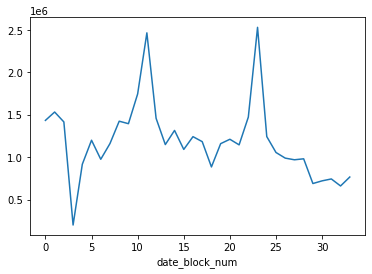

In [83]:
total_rev[total_rev['shop_id'] == 4].set_index('date_block_num')['revenue'].plot()

In [192]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [182]:
xgb_reg.score(X_train, y_train)

0.3492571986132471

In [183]:
xgb_reg.score(X_test, y_test)

0.3338165417624763